# **RUN this cell before you start**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
import string
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import urllib

# Topic Classfication with RNN (35 pts)
We will implement RNN for topic classification task.

## Preprocessing
**Do not modify the preprocessing codes.**
You only need to run the cells below.

In [2]:
# Download dataset
TRAIN_URL = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
urllib.request.urlretrieve(TRAIN_URL, "train.csv")
i2w = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}

In [3]:
df = pd.read_csv("train.csv", header=None, names=["label", "title", "text"])
df['label'] = df['label']-1
X,y = df['text'].values,df['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (96000,)
shape of test data is (24000,)


In [4]:
nltk.download('stopwords')
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    s = re.sub('br','', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:50000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train, dtype=object), np.array(final_list_test, dtype=object), onehot_dict

print("before tokenization:", x_train[1])
x_train, x_test ,vocab = tokenize(x_train,y_train,x_test,y_test)
print("after tokenization:", x_train[1])

print(f'Length of vocabulary is {len(vocab)}')

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

#we have very less number of reviews with length > 50.
#So we will consideronly those below it.
print("Before Padding:", x_train[0], len(x_train[0]))
x_train_pad = padding_(x_train,50)
print("After Padding:", x_train_pad[0], len(x_train_pad[0]))
x_test_pad = padding_(x_test,50)

[nltk_data] Downloading package stopwords to /home/jwjung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


before tokenization: WASHINGTON -- Federal regulators on Thursday adopted rules aimed at tempting electric utilities to offer broadband services -- a move officials hope will someday enable US consumers to jack in to the web from virtually any power outlet.
after tokenization: [56, 81, 687, 11, 3423, 981, 563, 14982, 2178, 7291, 305, 1142, 139, 192, 65, 825, 7462, 3617, 3, 611, 2418, 150, 4085, 315, 13466]
Length of vocabulary is 50000
Before Padding: [5, 7461, 2965, 838, 2833, 2245, 6912, 3119, 675, 116, 52, 5949, 30865, 2803] 14
After Padding: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     5  7461  2965   838  2833  2245  6912  3119   675   116    52  5949
 30865  2803] 50


In [5]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.nn.functional.one_hot(torch.from_numpy(y_train)))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.nn.functional.one_hot(torch.from_numpy(y_test)))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = next(iter(train_loader))

print("Total number of training data :", len(train_loader.dataset))
print("Total number of validation data :", len(valid_loader.dataset))
print('Sample batch size: ', sample_x.size()) # batch_size, seq_length
print('Sample x: \n', sample_x[0])
print('Sample y: \n', sample_y[0])

Total number of training data : 96000
Total number of validation data : 24000
Sample batch size:  torch.Size([128, 50])
Sample x: 
 tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    19,    25,  1240,   691, 10926,     3,   270,
         3742,   514,    79,   676,  5833,  1918,   297,   797,   189,  1230])
Sample y: 
 tensor([0, 0, 1, 0])


## Implementing an RNN model with PyTorch (15 pts)
In this question, we are going to implement a SimpleRNN class to classify AG news dataset. Complete the code following the instruction in the jupyter notebook file.


**(a)** Implement the `__init__()` function of **SimpleRNN** class. **(5 pts)**


**(b)** Implement the `forward()` function of SimpleRNN** class. **(10 pts)**

In [34]:
# Define RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, num_layers, output_dim, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SimpleRNN,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers
        self.vocab_size = vocab_size

        ### YOUR CODE HERE (~5 lines)
        ### TODO:
        ###     1. Initialize the RNN model using nn.RNN().
        self.rnn = nn.RNN(
            num_layers = num_layers,
            input_size = embedding_dim,
            hidden_size = hidden_dim,
            batch_first = True
        )
        ###     2. Initialize the embedding, dropout, linear, and softmax layers.
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        ### END YOUR CODE

    def forward(self, x):
        """ When sentences come in batch form, return the probability for each class.
        @param x (Tensor) : Tensor of padded sentences with shape (batch_size, sequence_length)
        @return output (Tensor): Tensor of the probability for each class with shape (batch_size, number_of_classes)
        """

        ### YOUR CODE HERE (~10 lines)
        ### TODO: Complete the forward pass using the layers declared in __init__ function.
        x = self.embedding(x) # (batch_size, sequence_length, embedding_dim)
        x, _ = self.rnn(x) # 
        output = self.dropout(x[:,-1,:])
        output = self.fc(output)
        output = self.softmax(output)
        ### END YOUR CODE

        return output

In [35]:
# DO NOT modify below hyperparameters. Just run the cell.
NUM_LAYERS = 2
VOCAB_SIZE = len(vocab) + 1 #extra 1 for padding
EMBEDDING_DIM = 128
OUTPUT_DIM = 4
HIDDEN_DIM = 256
LR=0.001
CLIP = 3
EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SimpleRNN(num_layers=NUM_LAYERS,
                  output_dim=OUTPUT_DIM,
                  vocab_size=VOCAB_SIZE,
                  hidden_dim=HIDDEN_DIM,
                  embedding_dim=EMBEDDING_DIM,
                  drop_prob=0.5)

#moving to gpu
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Device :", device)
print(model)

Device : cuda:0
SimpleRNN(
  (rnn): RNN(128, 256, num_layers=2, batch_first=True)
  (embedding): Embedding(50001, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


## Train and evaluate the RNN model (20 pts)
Next, we will train and evaluate the RNN model. Implement a train and evaluation code following the instruction in jupyter notebook file.


**(a)** Implement the `train()` function of Trainer class. **(8 pts)**


**(b)** After the training is complete, use the `plot()` function of Trainer class to display the figure, and then paste it here. **(4 pts)**


**(c)** Report the best validation accuracy using the print best acc() function of Trainer class. **(2 pts)**


**(d)** Based on (b) and (c), evaluate whether the training was successful, and write at least two ways to improve the model’s performance. **(6 pts)**

In [40]:
class Trainer():
  def __init__(self, model, train_loader, val_loader, criterion, optimizer):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.criterion = criterion
    self.optimizer = optimizer
    self.epoch_train_loss, self.epoch_val_loss, self.epoch_train_acc, self.epoch_val_acc = [], [], [], []

  def acc(self, pred, label):
    pred = torch.argmax(pred, dim=-1)
    label = torch.argmax(label, dim=-1)
    return torch.sum(pred == label).item()

  def train(self, epochs: int):
    if self.epoch_train_loss:
      self.epoch_train_loss, self.epoch_val_loss, self.epoch_train_acc, self.epoch_val_acc = [], [], [], []

    for epoch in range(epochs):
      ########### TRAIN ###########
      self.model.train()
      train_losses = []
      train_acc = 0.0
      for x, y in self.train_loader:
        ### YOUR CODE HERE (~9 lines)
        ### TODO:
        ###     1. Perform a forward pass on the SimpleRNN model.
        x,y = x.to(device), y.to(device)
        self.optimizer.zero_grad()
        output = self.model(x)
        
        ###     2. Calculate the train loss(train_loss) and perform backpropagation.
        loss = self.criterion(output.float(), y.float())
        loss.backward()
        self.optimizer.step()
        ###     3. Calculate the train accuracy(acc) using self.acc function.
        acc = self.acc(output, y)
        
        ###     4. Implement gradient clipping using the torch.nn.utils.clip_grad_norm_ function. You must use the 'CLIP' variable as the max_norm.
        nn.utils.clip_grad_norm_(self.model.parameters(), CLIP)
        train_loss = loss.detach().cpu().numpy()
        ### END YOUR CODE
        train_losses.append(train_loss)
        train_acc += acc


      ######### VALIDATION #########
      val_losses = []
      val_acc = 0.0
      self.model.eval()
      for x, y in self.val_loader:
        x, y = x.to(device), y.to(device)
        ### YOUR CODE HERE (~5 lines)
        ### TODO:
        ###     1. Perform a forward pass on the SimpleRNN model.
        ###     2. Calculate the validation loss(val_loss) and validation accuracy(acc)
        with torch.no_grad():
          output = self.model(x)

        val_loss = self.criterion(output.float(), y.float())
        acc = self.acc(output, y)

        val_loss = val_loss.detach().cpu().numpy()
        ### END YOUR CODE
        val_losses.append(val_loss)
        val_acc += acc

      ### DO NOT modify below codes
      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)
      train_acc = train_acc/len(self.train_loader.dataset)
      val_acc = val_acc/len(self.val_loader.dataset)
      self.epoch_train_loss.append(train_loss)
      self.epoch_val_loss.append(val_loss)
      self.epoch_train_acc.append(train_acc)
      self.epoch_val_acc.append(val_acc)
      print(f'Epoch {epoch+1}')
      print(f'train_loss : {train_loss} val_loss : {val_loss}')
      print(f'train_accuracy : {train_acc*100} val_accuracy : {val_acc*100}')

  def print_best_acc(self):
    print(f"Best accuracy -> {max(self.epoch_val_acc)*100}")

  def plot(self):
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(self.epoch_train_acc, label='Train Acc')
    plt.plot(self.epoch_val_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(self.epoch_train_loss, label='Train loss')
    plt.plot(self.epoch_val_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1
train_loss : 0.8317789435386658 val_loss : 0.8712802529335022
train_accuracy : 91.14166666666667 val_accuracy : 87.14583333333333
Epoch 2
train_loss : 0.8306591510772705 val_loss : 0.885628879070282
train_accuracy : 91.24791666666667 val_accuracy : 85.75
Epoch 3
train_loss : 0.8377978801727295 val_loss : 0.8804556131362915
train_accuracy : 90.53020833333333 val_accuracy : 86.18333333333334
Epoch 4
train_loss : 0.8254804611206055 val_loss : 0.8634732961654663
train_accuracy : 91.7625 val_accuracy : 87.97083333333333
Epoch 5
train_loss : 0.8298673629760742 val_loss : 0.8716604113578796
train_accuracy : 91.33125 val_accuracy : 87.09166666666667
Epoch 6
train_loss : 0.8284648656845093 val_loss : 0.8658779859542847
train_accuracy : 91.478125 val_accuracy : 87.70416666666667
Epoch 7
train_loss : 0.8228267431259155 val_loss : 0.8661845326423645
train_accuracy : 92.05104166666666 val_accuracy : 87.625
Epoch 8
train_loss : 0.8251632452011108 val_loss : 0.8673392534255981
train_accuracy 

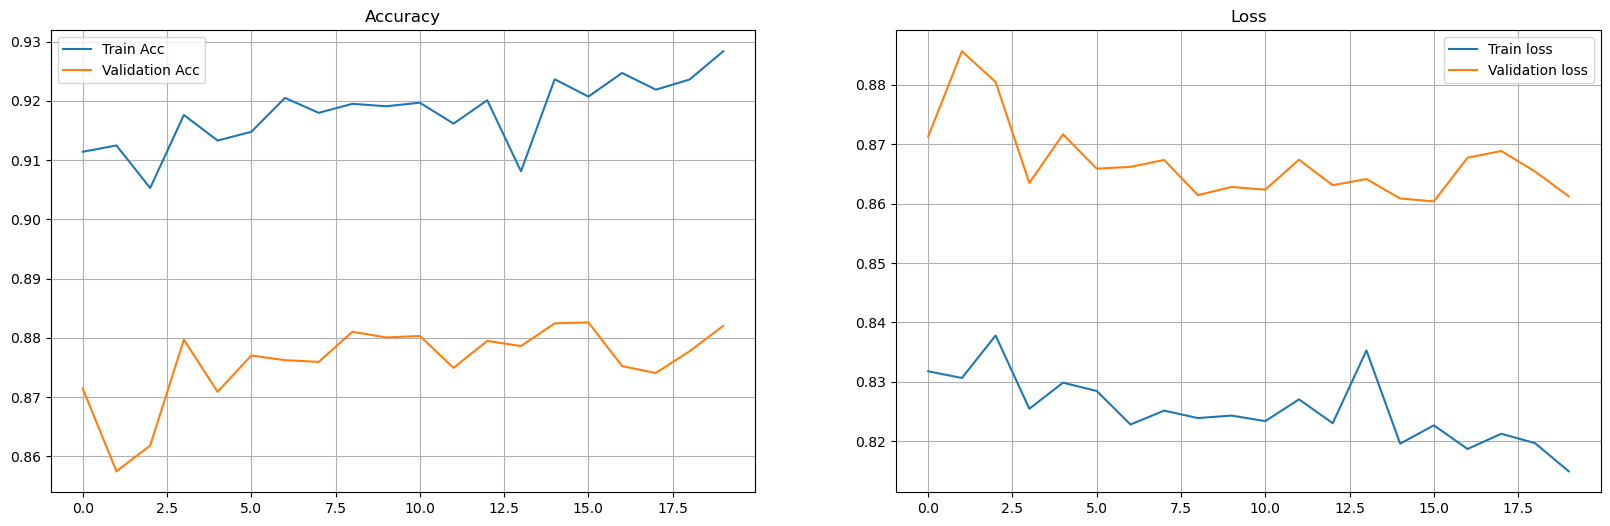

In [41]:
trainer= Trainer(model=model,
                 train_loader=train_loader,
                 val_loader=valid_loader,
                 criterion=criterion,
                 optimizer=optimizer)
trainer.train(EPOCHS)
trainer.print_best_acc()
trainer.plot()